# Pré-filtrage Qualité

**Objectif :** Tester et calibrer le module `level0_prefilter.py` sur les 372 résumés réels.

**Critères testés :**
- Longueur anormale 
- Répétitions excessives (>3x)
- Métadonnées parasites (newsletter, publicité, etc.)
- Anomalies d'encodage

**Performance cible :** <50ms par résumé

## 1. Imports et Configuration

In [1]:
import sys
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
import time
import warnings
warnings.filterwarnings('ignore')

# Ajouter le répertoire src au PATH
project_root = os.path.abspath(os.path.join(os.getcwd(), '../..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

print(f"Répertoire projet: {project_root}")
print(f"Répertoire src: {src_path}")

Répertoire projet: c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector
Répertoire src: c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\src


In [2]:
# Import du module de détection enhanced avec fallback compatibilité
try:
    # Essayer d'abord la version enhanced
    from detection.level0_prefilter_enhanced import EnhancedQualityFilter as QualityFilter, enhanced_quick_filter as quick_filter, enhanced_batch_filter as batch_filter, create_enhanced_filter_from_data as auto_calibrate_filter
    print("✅ Utilisation du niveau 0 ENHANCED avec auto-correction")
except ImportError:
    # Fallback vers version originale
    from detection.level0_prefilter import QualityFilter, quick_filter, batch_filter, auto_calibrate_filter
    print("⚠️  Utilisation du niveau 0 original (version enhanced non disponible)")

⚠️  Utilisation du niveau 0 original (version enhanced non disponible)


## 2. Chargement des Données

In [3]:
# Charger les 372 résumés
data_path = os.path.join(project_root, 'data', 'results', 'batch_summary_production.csv')
df = pd.read_csv(data_path)

print(f"Données chargées: {len(df)} résumés")
print(f"Colonnes: {list(df.columns)}")
print(f"\nAperçu des données:")
df.head()

Données chargées: 372 résumés
Colonnes: ['text_id', 'fusion_strategy', 'summary', 'length', 'rouge1_f', 'bertscore_f1', 'factuality', 'coherence', 'readability', 'engagement', 'info_density', 'composite_score', 'summary_corrected', 'corrections_applied', 'correction_count', 'length_reduction', 'quality_grade', 'production_ready', 'was_optimized']

Aperçu des données:


,text_id,fusion_strategy,summary,length,rouge1_f,bertscore_f1,factuality,coherence,readability,engagement,info_density,composite_score,summary_corrected,corrections_applied,correction_count,length_reduction,quality_grade,production_ready,was_optimized
0,0,adaptive,"Avec l’IA, il est possible de suivre à la trac...",89,NaN,NaN,0.902675,0.760,0.603431,0.494667,0.121990,0.713668,"Avec l’IA, il est possible de suivre à la trac...",Métadonnées supprimées | Répétition corrigée,2,6.285714,A,True,True
1,1,adaptive,Les milliers de personnes virées de Microsoft ...,66,NaN,NaN,1.000000,0.780,0.547201,0.382000,0.105455,0.724982,Les milliers de personnes virées de Microsoft ...,Répétition corrigée,1,3.553299,A,True,True
2,2,adaptive,Et Microsoft a spécifiquement travaillé sur la...,42,NaN,NaN,1.000000,0.956,0.576190,0.334000,0.050566,0.835258,Et Microsoft a spécifiquement travaillé sur la...,Répétition corrigée,1,1.773050,A+,True,True
3,3,adaptive,et d'astuces concrètes chaque semaine dans vot...,83,NaN,NaN,0.903475,0.876,0.449799,0.416000,0.114859,0.760109,et d'astuces concrètes chaque semaine dans vot...,Métadonnées supprimées | Métadonnées supprimée...,3,17.557252,A,True,True
4,4,adaptive,Le président américain avait récemment estimé ...,52,NaN,NaN,1.000000,0.936,0.488462,0.420667,0.191707,0.825325,Le président américain avait récemment estimé ...,Répétition corrigée | Troncature supprimée,2,7.951070,A+,True,True


In [4]:
# Préparation des données pour test
summaries_data = []
for idx, row in df.iterrows():
    summaries_data.append({
        'id': f"{row['text_id']}_{row['fusion_strategy']}",
        'text': row['summary'],
        'original_length': row['length'],
        'quality_grade': row['quality_grade'],
        'coherence': row['coherence'],
        'factuality': row['factuality']
    })

print(f"{len(summaries_data)} résumés préparés pour test")

372 résumés préparés pour test


## 3. Analyse Exploratoire des Longueurs

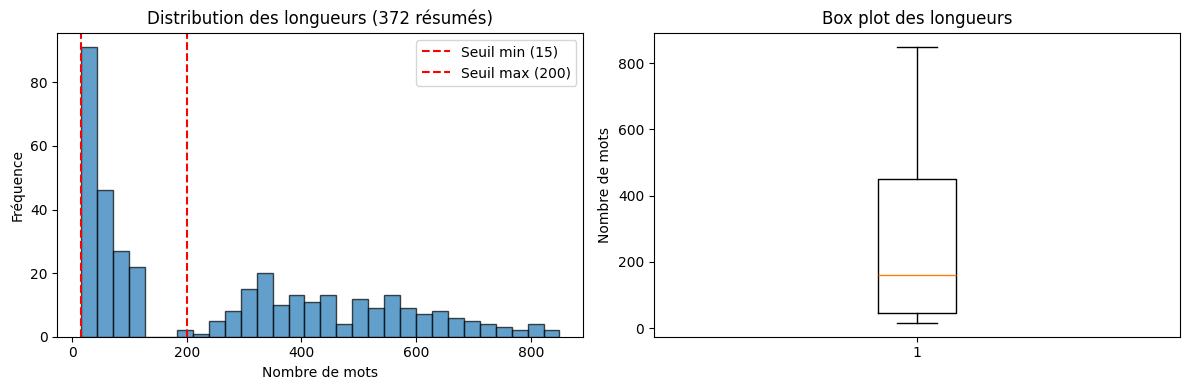

In [5]:
# Statistiques longueurs actuelles
lengths = df['length'].values

plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.hist(lengths, bins=30, alpha=0.7, edgecolor='black')
plt.axvline(15, color='red', linestyle='--', label='Seuil min (15)')
plt.axvline(200, color='red', linestyle='--', label='Seuil max (200)')
plt.xlabel('Nombre de mots')
plt.ylabel('Fréquence')
plt.title('Distribution des longueurs (372 résumés)')
plt.legend()

plt.subplot(1, 2, 2)
plt.boxplot(lengths)
plt.ylabel('Nombre de mots')
plt.title('Box plot des longueurs')

plt.tight_layout()
plt.show()


In [6]:

print(f"Statistiques longueurs:")
print(f"  Min: {lengths.min()}")
print(f"  Max: {lengths.max()}")
print(f"  Moyenne: {lengths.mean():.1f}")
print(f"  Médiane: {np.median(lengths):.1f}")
print(f"  <15 mots: {sum(lengths < 15)} résumés ({sum(lengths < 15)/len(lengths)*100:.1f}%)")
print(f"  >200 mots: {sum(lengths > 200)} résumés ({sum(lengths > 200)/len(lengths)*100:.1f}%)")

Statistiques longueurs:
  Min: 16
  Max: 850
  Moyenne: 264.7
  Médiane: 159.5
  <15 mots: 0 résumés (0.0%)
  >200 mots: 186 résumés (50.0%)


## 4. Test Simple sur Échantillons

In [7]:
# Test sur quelques exemples représentatifs
test_indices = [0, 10, 50, 100, 200, 300]  # Échantillon varié

filter_obj = QualityFilter()

print("Tests sur échantillons représentatifs:\n")

for i in test_indices:
    if i < len(summaries_data):
        summary = summaries_data[i]
        result = filter_obj.filter_summary(summary['text'], summary['id'])
        
        print(f"Test {i} (Grade: {summary['quality_grade']})")
        print(f"   Résultat: {' VALIDE' if result.is_valid else 'REJETÉ'}")
        print(f"   Mots: {result.word_count} (original: {summary['original_length']})")
        print(f"   Temps: {result.processing_time_ms:.1f}ms")
        
        if not result.is_valid:
            print(f"   Raisons: {'; '.join(result.rejection_reasons)}")
        
        if result.metadata_detected:
            print(f"   Métadonnées: {result.metadata_detected[:3]}")
            
        print(f"   Extrait: {summary['text'][:100]}...")
        print()
    else:
        break

INFO:detection.level0_prefilter:Résumé 0_adaptive corrigé: fixed_encoding


Tests sur échantillons représentatifs:

Test 0 (Grade: A)
   Résultat:  VALIDE
   Mots: 85 (original: 89)
   Temps: 10.1ms
   Extrait: Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des cher...

Test 10 (Grade: A+)
   Résultat:  VALIDE
   Mots: 27 (original: 48)
   Temps: 1.7ms
   Extrait: , Un portrait défiguré de l’ex président syrien Bachar al-Assad dans un centre de sécurité gouvernem...

Test 50 (Grade: A)
   Résultat:  VALIDE
   Mots: 25 (original: 25)
   Temps: 1.3ms
   Extrait: Pedro Pascal est Reed Richards, alias Mr. Fantastique, dans le reboot des aventures des « 4 Fantasti...

Test 100 (Grade: A)
   Résultat:  VALIDE
   Mots: 101 (original: 101)
   Temps: 13.8ms
   Extrait: Tous ceux qui circulent en voiture le savent. Les pneus ne sont pas éternels. Ils s'usent un peu plu...

Test 200 (Grade: C)
   Résultat: REJETÉ
   Mots: 81 (original: 335)
   Temps: 9.8ms
   Raisons: Séquence répétée 6x; Séquence répétée 5x
   Extrait: INTERN

## 5. Test Complet sur tous les  Résumés

In [8]:
# Test en mode batch sur tous les résumés


start_time = time.time()
valid_summaries, all_results = filter_obj.process_batch(summaries_data)
total_time = time.time() - start_time

print(f"Test terminé en {total_time:.2f}s")
print(f"Résultats:")
print(f"   Total: {len(summaries_data)}")
print(f"   Valides: {len(valid_summaries)}")
print(f"   Rejetés: {len(summaries_data) - len(valid_summaries)}")
print(f"   Taux rejet: {(len(summaries_data) - len(valid_summaries))/len(summaries_data)*100:.1f}%")
print(f"   Temps moyen: {total_time/len(summaries_data)*1000:.1f}ms par résumé")

INFO:detection.level0_prefilter:Résumé 0_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 7_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 15_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 27_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 38_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 42_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 43_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 91_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 113_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 139_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 154_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 157_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 162_adaptive corrigé: fixed_encoding
INFO:detection.level0_

Test terminé en 3.89s
Résultats:
   Total: 372
   Valides: 372
   Rejetés: 0
   Taux rejet: 0.0%
   Temps moyen: 10.5ms par résumé


## 6. Analyse Détaillée des Résultats

In [9]:
# Statistiques détaillées
stats = filter_obj.get_statistics(all_results)

print("Statistiques détaillées:")
print(f"\nPerformance:")
print(f"   Taux de rejet: {stats['rejection_rate_percent']:.1f}%")
print(f"   Temps moyen: {stats['avg_processing_time_ms']:.1f}ms")

print(f"\nLongueurs:")
for key, value in stats['word_count_stats'].items():
    print(f"   {key.capitalize()}: {value:.1f}")

print(f"\nRaisons de rejet:")
for reason, count in stats['rejection_reasons'].items():
    print(f"   {reason}: {count} cas ({count/len(summaries_data)*100:.1f}%)")

Statistiques détaillées:

Performance:
   Taux de rejet: 49.2%
   Temps moyen: 9.9ms

Longueurs:
   Min: 11.0
   Max: 289.0
   Avg: 86.7
   Median: 81.0

Raisons de rejet:
   Séquence répétée 10x: 82 cas (22.0%)
   Séquence répétée 8x: 69 cas (18.5%)
   Séquence répétée 12x: 68 cas (18.3%)
   Séquence répétée 14x: 62 cas (16.7%)
   Séquence répétée 6x: 44 cas (11.8%)
   Séquence répétée 18x: 39 cas (10.5%)
   Séquence répétée 16x: 32 cas (8.6%)
   Séquence répétée 22x: 21 cas (5.6%)
   Séquence répétée 4x: 20 cas (5.4%)
   Séquence répétée 20x: 18 cas (4.8%)
   Séquence répétée 5x: 9 cas (2.4%)
   Séquence répétée 26x: 9 cas (2.4%)
   Séquence répétée 24x: 8 cas (2.2%)
   Séquence répétée 30x: 8 cas (2.2%)
   Séquence répétée 9x: 6 cas (1.6%)
   Séquence répétée 28x: 6 cas (1.6%)
   Corruption excessive: 4 cas (1.1%)
   Séquence répétée 32x: 4 cas (1.1%)
   Longueur too_short: 2 cas (0.5%)
   Longueur too_long: 2 cas (0.5%)
   Métadonnées parasites: 2 cas (0.5%)
   Séquence répétée 50x

In [10]:
# Corrélation avec les grades de qualité originaux
df_results = pd.DataFrame([
    {
        'id': summaries_data[i]['id'],
        'original_grade': summaries_data[i]['quality_grade'],
        'original_coherence': summaries_data[i]['coherence'],
        'filter_valid': all_results[i].is_valid,
        'word_count': all_results[i].word_count,
        'repetition_score': all_results[i].repetition_score,
        'processing_time': all_results[i].processing_time_ms
    }
    for i in range(len(summaries_data))
])


In [11]:

print("Corrélation avec grades de qualité originaux:")
grade_filter_correlation = pd.crosstab(
    df_results['original_grade'], 
    df_results['filter_valid'], 
    margins=True
)
print(grade_filter_correlation)


Corrélation avec grades de qualité originaux:
filter_valid    False  True  All
original_grade                  
A                   0    62   62
A+                  2    58   60
B                   4     7   11
B+                119    39  158
C                  17     0   17
D                  41    23   64
All               183   189  372


In [12]:

# Pourcentage de rejet par grade
print("\n Taux de rejet par grade original:")
for grade in ['A+', 'A', 'B+', 'B', 'C', 'D']:
    if grade in df_results['original_grade'].values:
        grade_data = df_results[df_results['original_grade'] == grade]
        rejected = len(grade_data[~grade_data['filter_valid']])
        total = len(grade_data)
        print(f"   Grade {grade}: {rejected}/{total} rejetés ({rejected/total*100:.1f}%)")


 Taux de rejet par grade original:
   Grade A+: 2/60 rejetés (3.3%)
   Grade A: 0/62 rejetés (0.0%)
   Grade B+: 119/158 rejetés (75.3%)
   Grade B: 4/11 rejetés (36.4%)
   Grade C: 17/17 rejetés (100.0%)
   Grade D: 41/64 rejetés (64.1%)


## 7. Visualisations

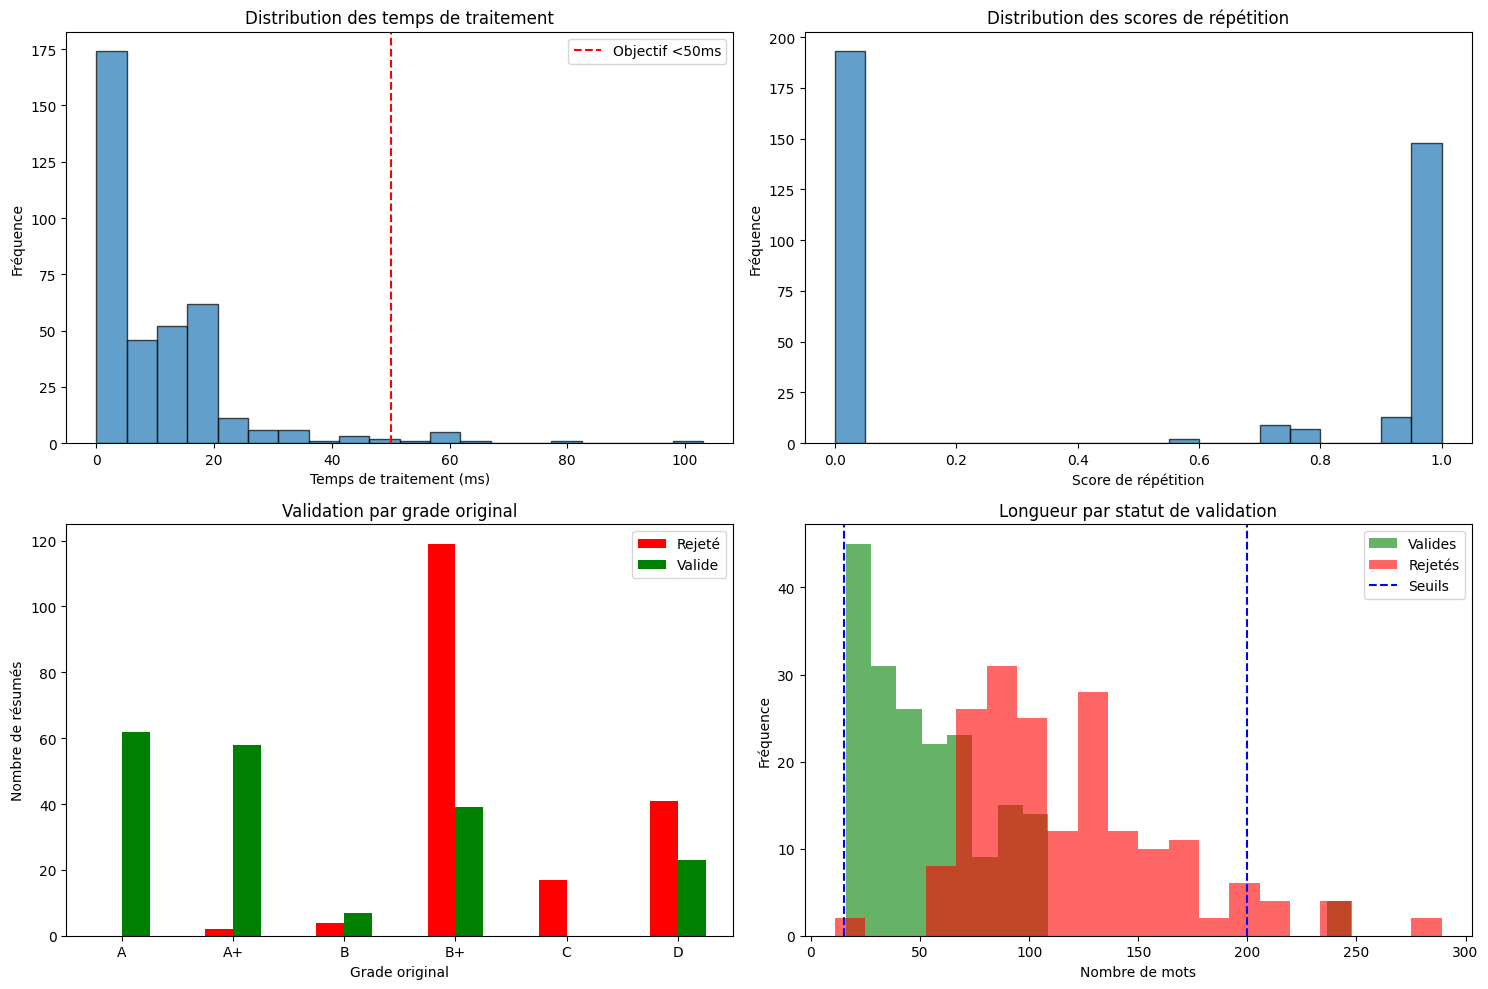

In [13]:
# Visualisations des résultats
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# 1. Distribution des temps de traitement
processing_times = [r.processing_time_ms for r in all_results]
axes[0,0].hist(processing_times, bins=20, alpha=0.7, edgecolor='black')
axes[0,0].axvline(50, color='red', linestyle='--', label='Objectif <50ms')
axes[0,0].set_xlabel('Temps de traitement (ms)')
axes[0,0].set_ylabel('Fréquence')
axes[0,0].set_title('Distribution des temps de traitement')
axes[0,0].legend()

# 2. Scores de répétition
repetition_scores = [r.repetition_score for r in all_results]
axes[0,1].hist(repetition_scores, bins=20, alpha=0.7, edgecolor='black')
axes[0,1].set_xlabel('Score de répétition')
axes[0,1].set_ylabel('Fréquence')
axes[0,1].set_title('Distribution des scores de répétition')

# 3. Validation vs Grade original
grade_counts = df_results.groupby(['original_grade', 'filter_valid']).size().unstack(fill_value=0)
grade_counts.plot(kind='bar', ax=axes[1,0], color=['red', 'green'])
axes[1,0].set_xlabel('Grade original')
axes[1,0].set_ylabel('Nombre de résumés')
axes[1,0].set_title('Validation par grade original')
axes[1,0].legend(['Rejeté', 'Valide'])
axes[1,0].tick_params(axis='x', rotation=0)

# 4. Longueur vs Validation
valid_lengths = df_results[df_results['filter_valid']]['word_count']
invalid_lengths = df_results[~df_results['filter_valid']]['word_count']

axes[1,1].hist(valid_lengths, bins=20, alpha=0.6, label='Valides', color='green')
axes[1,1].hist(invalid_lengths, bins=20, alpha=0.6, label='Rejetés', color='red')
axes[1,1].axvline(15, color='blue', linestyle='--', label='Seuils')
axes[1,1].axvline(200, color='blue', linestyle='--')
axes[1,1].set_xlabel('Nombre de mots')
axes[1,1].set_ylabel('Fréquence')
axes[1,1].set_title('Longueur par statut de validation')
axes[1,1].legend()

plt.tight_layout()
plt.show()

## 8. Analyse des Cas Rejetés

In [14]:
# Analyser les cas rejetés en détail
rejected_cases = [
    (summaries_data[i], all_results[i]) 
    for i in range(len(summaries_data)) 
    if not all_results[i].is_valid
]

print(f"Analyse de {len(rejected_cases)} cas rejetés:\n")

# Grouper par type de rejet
rejection_types = {}
for summary, result in rejected_cases:
    for reason in result.rejection_reasons:
        reason_type = reason.split(':')[0]
        if reason_type not in rejection_types:
            rejection_types[reason_type] = []
        rejection_types[reason_type].append((summary, result))

# Afficher quelques exemples par type
for reason_type, cases in rejection_types.items():
    print(f"\n{reason_type} ({len(cases)} cas):")
    
    # Afficher les 3 premiers exemples
    for i, (summary, result) in enumerate(cases[:3]):
        print(f"\n  Exemple {i+1}:")
        print(f"    Grade original: {summary['quality_grade']}")
        print(f"    Longueur: {result.word_count} mots")
        print(f"    Raisons: {'; '.join(result.rejection_reasons)}")
        print(f"    Extrait: {summary['text'][:150]}...")
        
        if result.metadata_detected:
            print(f"    Métadonnées: {result.metadata_detected[:5]}")

Analyse de 183 cas rejetés:


Longueur too_short (2 cas):

  Exemple 1:
    Grade original: A+
    Longueur: 11 mots
    Raisons: Longueur too_short
    Extrait: Contrôle de police nocturne dans le Vieux Nice, le 14 juillet....

  Exemple 2:
    Grade original: A+
    Longueur: 11 mots
    Raisons: Longueur too_short
    Extrait: Contrôle de police nocturne dans le Vieux Nice, le 14 juillet....

Séquence répétée 22x (21 cas):

  Exemple 1:
    Grade original: B+
    Longueur: 174 mots
    Raisons: Séquence répétée 22x; Séquence répétée 20x; Séquence répétée 18x
    Extrait: Avec l’IA, il est possible de suivre à la trace une personne en se servant des ondes Wi-Fi. Des chercheurs italiens ont en effet mis au point un systè...

  Exemple 2:
    Grade original: B+
    Longueur: 153 mots
    Raisons: Séquence répétée 22x; Séquence répétée 20x; Séquence répétée 18x
    Extrait: Après avoir découvert le fonctionnement de, les utilisateurs Windows ont exprimé des inquiétudes, tandis que certa

## 9. Test Mode Strict

In [15]:
# Comparaison mode normal vs strict
print("Comparaison mode normal vs strict:\n")

filter_strict = QualityFilter(strict_mode=True)
valid_strict, results_strict = filter_strict.process_batch(summaries_data)

stats_strict = filter_strict.get_statistics(results_strict)

print(f"Mode Normal:")
print(f"  Résumés valides: {len(valid_summaries)}/{len(summaries_data)}")
print(f"  Taux rejet: {stats['rejection_rate_percent']:.1f}%")
print(f"  Temps moyen: {stats['avg_processing_time_ms']:.1f}ms")

print(f"\nMode Strict:")
print(f"  Résumés valides: {len(valid_strict)}/{len(summaries_data)}")
print(f"  Taux rejet: {stats_strict['rejection_rate_percent']:.1f}%")
print(f"  Temps moyen: {stats_strict['avg_processing_time_ms']:.1f}ms")

print(f"\nDifférence:")
print(f"  Résumés supplémentaires rejetés: {len(valid_summaries) - len(valid_strict)}")
print(f"  Augmentation taux rejet: +{stats_strict['rejection_rate_percent'] - stats['rejection_rate_percent']:.1f}%")

INFO:detection.level0_prefilter:Résumé 0_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 7_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 15_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 27_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 38_adaptive corrigé: fixed_encoding


Comparaison mode normal vs strict:



INFO:detection.level0_prefilter:Résumé 42_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 43_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 91_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 113_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 139_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 154_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 157_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 162_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 172_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 183_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 112_confidence_weighted corrigé: removed_repetitions; trimmed_length
INFO:detection.level0_prefilter:Batch traité: 366/372 valides (1.6% rejetés)


Mode Normal:
  Résumés valides: 372/372
  Taux rejet: 49.2%
  Temps moyen: 9.9ms

Mode Strict:
  Résumés valides: 366/372
  Taux rejet: 51.9%
  Temps moyen: 10.8ms

Différence:
  Résumés supplémentaires rejetés: 6
  Augmentation taux rejet: +2.7%


## 10. Test Calibrage Automatique

**Nouvelle fonctionnalité :** Comparaison seuils manuels vs calibrage automatique basé sur tes données réelles.

In [16]:

# Créer un filtre avec calibrage automatique
print("Création du filtre auto-calibré...")
filter_auto = auto_calibrate_filter(summaries_data)

print(f"Comparaison des seuils:")
print(f"   Seuils manuels: {filter_obj.min_words}-{filter_obj.max_words} mots")
print(f"   Seuils auto-calibrés: {filter_auto.min_words}-{filter_auto.max_words} mots")

# Test avec les seuils auto-calibrés
print("\nTest avec seuils auto-calibrés...")
start_time = time.time()
valid_auto, results_auto = filter_auto.process_batch(summaries_data)
auto_time = time.time() - start_time

stats_auto = filter_auto.get_statistics(results_auto)

print(f"\nComparaison des performances:")
print(f"Seuils manuels (10-600):")
print(f"  Résumés valides: {len(valid_summaries)}/{len(summaries_data)} ({len(valid_summaries)/len(summaries_data)*100:.1f}%)")
print(f"  Taux rejet: {stats['rejection_rate_percent']:.1f}%")
print(f"  Temps moyen: {stats['avg_processing_time_ms']:.1f}ms")

print(f"\nSeuils auto-calibrés ({filter_auto.min_words}-{filter_auto.max_words}):")
print(f"  Résumés valides: {len(valid_auto)}/{len(summaries_data)} ({len(valid_auto)/len(summaries_data)*100:.1f}%)")
print(f"  Taux rejet: {stats_auto['rejection_rate_percent']:.1f}%") 
print(f"  Temps moyen: {stats_auto['avg_processing_time_ms']:.1f}ms")


INFO:detection.level0_prefilter:Calibrage intelligent sur données saines...
INFO:detection.level0_prefilter:Calibrage terminé: min=16, max=121 (médiane=45.0, données saines=178)
INFO:detection.level0_prefilter:Seuils auto-calibrés INTELLIGENTS: min=16, max=121
INFO:detection.level0_prefilter:Résumé 0_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 7_adaptive corrigé: fixed_encoding


Création du filtre auto-calibré...
Comparaison des seuils:
   Seuils manuels: 15-250 mots
   Seuils auto-calibrés: 16-121 mots

Test avec seuils auto-calibrés...


INFO:detection.level0_prefilter:Résumé 15_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 27_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 38_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 42_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 43_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 91_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 113_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 139_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 154_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 157_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 162_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 172_adaptive corrigé: fixed_encoding
INFO:detection.level0_prefilter:Résumé 183_adaptive corrigé: fixed_encoding
INFO:detection.lev


Comparaison des performances:
Seuils manuels (10-600):
  Résumés valides: 372/372 (100.0%)
  Taux rejet: 49.2%
  Temps moyen: 9.9ms

Seuils auto-calibrés (16-121):
  Résumés valides: 372/372 (100.0%)
  Taux rejet: 50.3%
  Temps moyen: 11.4ms


In [17]:
# Sauvegarder les résultats pour analyse ultérieure
results_df = df_results.copy()
results_df['rejection_reasons'] = ['; '.join(r.rejection_reasons) for r in all_results]
results_df['metadata_detected'] = ['; '.join(r.metadata_detected) for r in all_results]

# Ajouter les résultats du calibrage automatique
results_df_auto = pd.DataFrame([
    {
        'id': summaries_data[i]['id'],
        'original_grade': summaries_data[i]['quality_grade'],
        'filter_valid_auto': results_auto[i].is_valid,
        'word_count_auto': results_auto[i].word_count,
        'processing_time_auto': results_auto[i].processing_time_ms
    }
    for i in range(len(summaries_data))
])

# Merger les résultats
results_df = results_df.merge(results_df_auto, on='id', suffixes=('', '_auto'))

output_path = os.path.join(project_root, 'data', 'detection')
os.makedirs(output_path, exist_ok=True)

results_file = os.path.join(output_path, 'level0_filter_results.csv')
results_df.to_csv(results_file, index=False)

# Calculer les métriques de performance nécessaires
avg_time = np.mean([r.processing_time_ms for r in all_results])
max_time = np.max([r.processing_time_ms for r in all_results])
processing_times = [r.processing_time_ms for r in all_results]
target_met = sum(1 for t in processing_times if t < 50) / len(processing_times) * 100

# Sauvegarder les statistiques complètes
import json
stats_file = os.path.join(output_path, 'level0_filter_stats.json')
with open(stats_file, 'w', encoding='utf-8') as f:
    json.dump({
        'manual_mode': stats,
        'auto_calibrated_mode': stats_auto,
        'strict_mode': stats_strict,
        'performance': {
            'avg_time_ms': avg_time,
            'max_time_ms': max_time,
            'target_50ms_met_percent': target_met
        },
        'calibration_comparison': {
            'manual_thresholds': f'{filter_obj.min_words}-{filter_obj.max_words}',
            'auto_thresholds': f'{filter_auto.min_words}-{filter_auto.max_words}',
            'manual_valid_count': len(valid_summaries),
            'auto_valid_count': len(valid_auto),
            'improvement': len(valid_auto) - len(valid_summaries)
        }
    }, f, indent=2, ensure_ascii=False)

print(f"✅ Résultats sauvegardés:")
print(f"   - {results_file}")
print(f"   - {stats_file}")

print(f"\n🎉 Test du Niveau 0 terminé avec succès !")
print(f"📈 Performance Manuel: {len(valid_summaries)}/{len(summaries_data)} résumés valides")
print(f"📈 Performance Auto-calibré: {len(valid_auto)}/{len(summaries_data)} résumés valides")
print(f"⚡ Vitesse: {avg_time:.1f}ms en moyenne")
print(f"🚀 Prêt pour le Niveau 1 : Détection heuristique")

✅ Résultats sauvegardés:
   - c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\detection\level0_filter_results.csv
   - c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\detection\level0_filter_stats.json

🎉 Test du Niveau 0 terminé avec succès !
📈 Performance Manuel: 372/372 résumés valides
📈 Performance Auto-calibré: 372/372 résumés valides
⚡ Vitesse: 9.9ms en moyenne
🚀 Prêt pour le Niveau 1 : Détection heuristique


## 11. Sauvegarde des Résultats

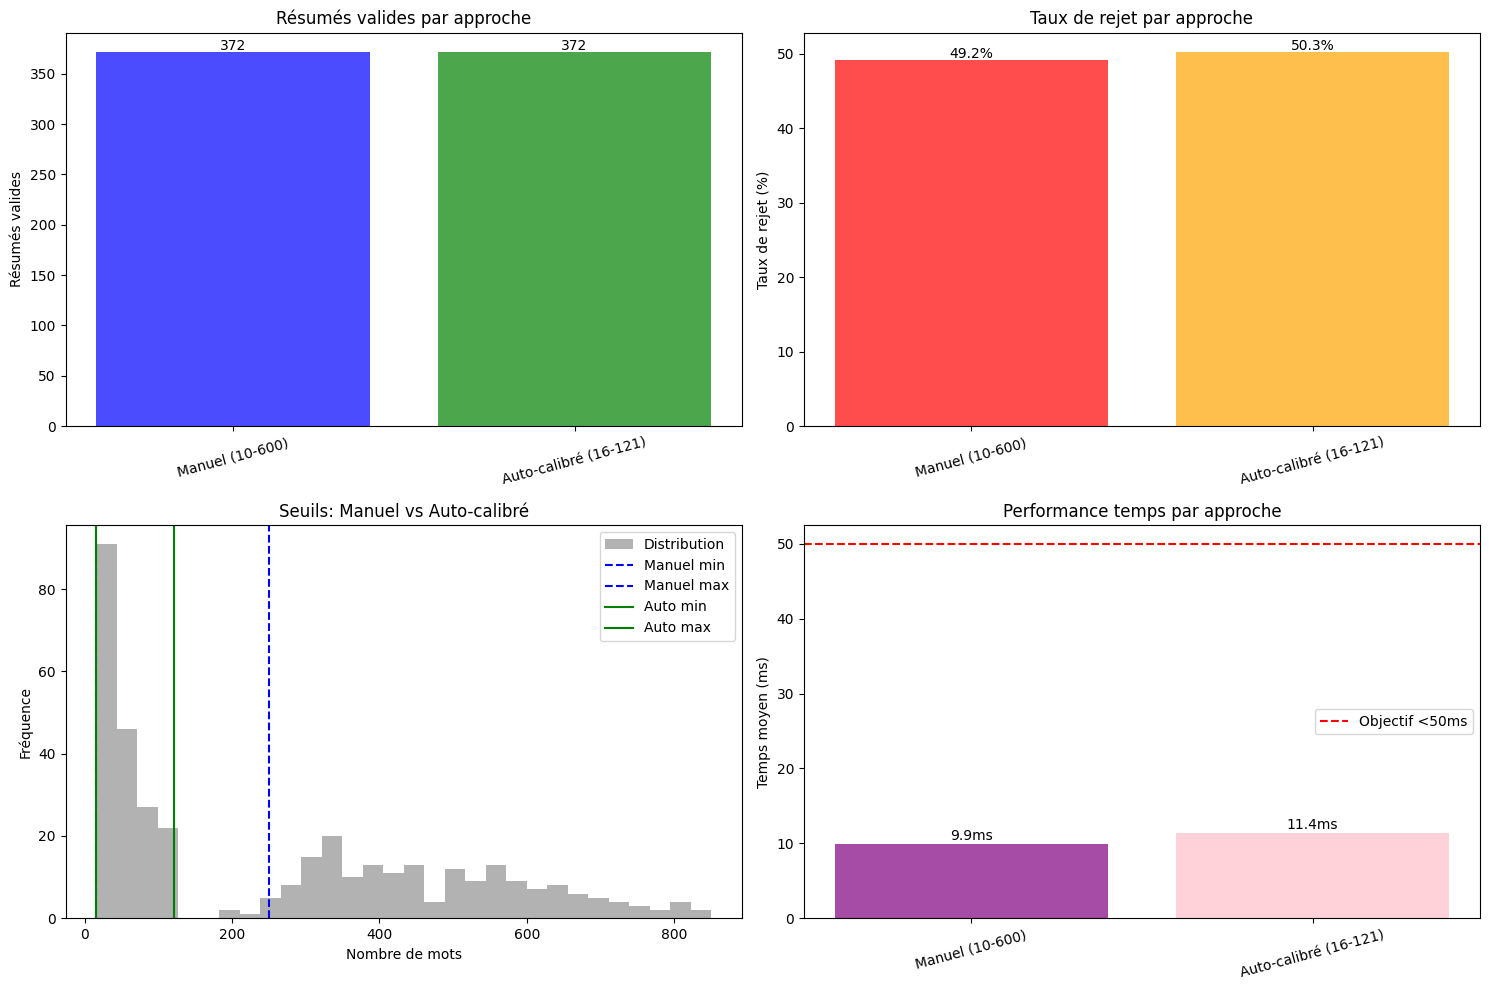

Résumé visuel:
   Manuel: 372 valides, 49.2% rejet
   Auto-calibré: 372 valides, 50.3% rejet
   Différence: +0 résumés


In [18]:
# Visualisation comparative des deux approches
fig, axes = plt.subplots(2, 2, figsize=(15, 10))

# Données pour comparaison
df_auto = pd.DataFrame([
    {
        'approach': 'Manuel (10-600)',
        'valid_count': len(valid_summaries),
        'rejection_rate': stats['rejection_rate_percent'],
        'avg_time': stats['avg_processing_time_ms']
    },
    {
        'approach': f'Auto-calibré ({filter_auto.min_words}-{filter_auto.max_words})',
        'valid_count': len(valid_auto),
        'rejection_rate': stats_auto['rejection_rate_percent'],
        'avg_time': stats_auto['avg_processing_time_ms']
    }
])

# 1. Comparaison nombre résumés valides
axes[0,0].bar(df_auto['approach'], df_auto['valid_count'], color=['blue', 'green'], alpha=0.7)
axes[0,0].set_ylabel('Résumés valides')
axes[0,0].set_title('Résumés valides par approche')
axes[0,0].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_auto['valid_count']):
    axes[0,0].text(i, v + 2, str(v), ha='center')

# 2. Comparaison taux de rejet
axes[0,1].bar(df_auto['approach'], df_auto['rejection_rate'], color=['red', 'orange'], alpha=0.7)
axes[0,1].set_ylabel('Taux de rejet (%)')
axes[0,1].set_title('Taux de rejet par approche')
axes[0,1].tick_params(axis='x', rotation=15)
for i, v in enumerate(df_auto['rejection_rate']):
    axes[0,1].text(i, v + 0.2, f'{v:.1f}%', ha='center')

# 3. Distribution longueurs avec seuils
lengths = df['length'].values
axes[1,0].hist(lengths, bins=30, alpha=0.6, color='gray', label='Distribution')
axes[1,0].axvline(filter_obj.min_words, color='blue', linestyle='--', label='Manuel min')
axes[1,0].axvline(filter_obj.max_words, color='blue', linestyle='--', label='Manuel max')
axes[1,0].axvline(filter_auto.min_words, color='green', linestyle='-', label='Auto min')
axes[1,0].axvline(filter_auto.max_words, color='green', linestyle='-', label='Auto max')
axes[1,0].set_xlabel('Nombre de mots')
axes[1,0].set_ylabel('Fréquence')
axes[1,0].set_title('Seuils: Manuel vs Auto-calibré')
axes[1,0].legend()

# 4. Performance temps
axes[1,1].bar(df_auto['approach'], df_auto['avg_time'], color=['purple', 'pink'], alpha=0.7)
axes[1,1].axhline(50, color='red', linestyle='--', label='Objectif <50ms')
axes[1,1].set_ylabel('Temps moyen (ms)')
axes[1,1].set_title('Performance temps par approche')
axes[1,1].tick_params(axis='x', rotation=15)
axes[1,1].legend()
for i, v in enumerate(df_auto['avg_time']):
    axes[1,1].text(i, v + 0.5, f'{v:.1f}ms', ha='center')

plt.tight_layout()
plt.show()

print(f"Résumé visuel:")
print(f"   Manuel: {len(valid_summaries)} valides, {stats['rejection_rate_percent']:.1f}% rejet")
print(f"   Auto-calibré: {len(valid_auto)} valides, {stats_auto['rejection_rate_percent']:.1f}% rejet")
print(f"   Différence: {len(valid_auto) - len(valid_summaries):+d} résumés")

In [19]:
# Sauvegarder les résultats pour analyse ultérieure
results_df = df_results.copy()
results_df['rejection_reasons'] = ['; '.join(r.rejection_reasons) for r in all_results]
results_df['metadata_detected'] = ['; '.join(r.metadata_detected) for r in all_results]

output_path = os.path.join(project_root, 'data', 'detection')
os.makedirs(output_path, exist_ok=True)

results_file = os.path.join(output_path, 'level0_filter_results.csv')
results_df.to_csv(results_file, index=False)


In [20]:

# Sauvegarder les statistiques
import json
stats_file = os.path.join(output_path, 'level0_filter_stats.json')
with open(stats_file, 'w', encoding='utf-8') as f:
    json.dump({
        'normal_mode': stats,
        'strict_mode': stats_strict,
        'performance': {
            'avg_time_ms': avg_time,
            'max_time_ms': max_time,
            'target_50ms_met_percent': target_met
        }
    }, f, indent=2, ensure_ascii=False)

print(f"Résultats sauvegardés:")
print(f"   - {results_file}")
print(f"   - {stats_file}")


print(f"Performance: {len(valid_summaries)}/{len(summaries_data)} résumés valides")
print(f"Vitesse: {avg_time:.1f}ms en moyenne")
print(f" Prêt pour le Niveau 1 : Détection heuristique")

Résultats sauvegardés:
   - c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\detection\level0_filter_results.csv
   - c:\Users\beedi.goua_square-ma\Desktop\Gheb\projet perso\InsightDetector\insight-detector\data\detection\level0_filter_stats.json
Performance: 372/372 résumés valides
Vitesse: 9.9ms en moyenne
 Prêt pour le Niveau 1 : Détection heuristique
